# **Pneumenia Disease Prediction On Chest X-rays**

# Overview

The task involves utilizing chest X-ray images to predict the presence of pneumonia disease.So it is a binary classification problem where we have two classes Pneumonoa and Normal. By employing statistics, machine learning and deep learning techniques,the goal is to develop an accurate and efficient predictive model for the early detection of pneumonia through the analysis of radiographic images.

# What is Pneumonia ?

Pneumonia is a respiratory infection that affects the lungs. It can be caused by different types of microorganisms, including bacteria, viruses, and fungi. The infection causes inflammation in the air sacs of the lungs ,causing the air sacs to fill with pus and other liquid  and leading to symptoms such as cough, difficulty breathing, chest pain, and fever.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

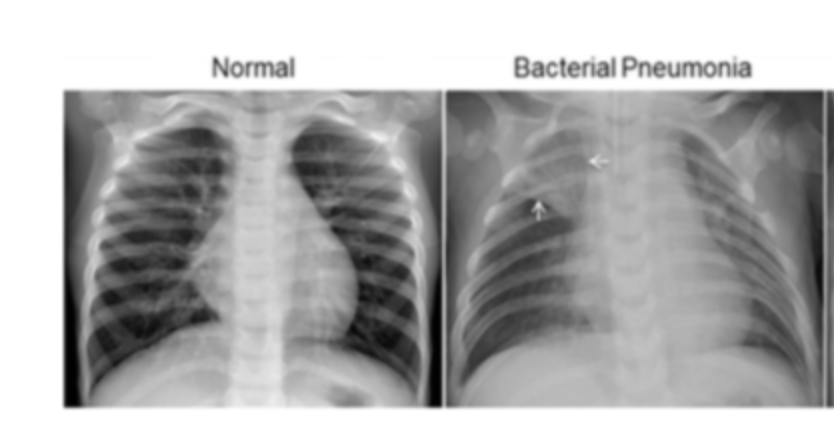

# How To Distinguish between a Pneumonia and a Normal chest X-ray?

Looking at the X-ray picture of Pneumonia infected person we can notice, In the middle panel,a cloudy or hazy area in the right upper part of the lung which is pointed out by white arrows.

What it means: This cloudy area is a sign of something not right. It's like a shadow or fog in a specific part of the lung.

## Importing Required Packages

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
from skimage.transform import resize
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score , auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import layers, models
from keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Ignore all warnings
warnings.filterwarnings("ignore")


/Users/adityasrivastava/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Exploratory Data Analysis

The provided Python code performs an exploratory data analysis (EDA) on a chest X-ray pneumonia detection dataset. It calculates and visualizes the distribution of pneumonia and normal samples in both the training and testing sets. The bar plots showcase the count of each class (PNEUMONIA and NORMAL) in a clear and informative manner. This analysis provides insights into the dataset's class distribution, helping researchers and practitioners understand the balance and characteristics of the data, which is crucial for building effective machine learning models for pneumonia detection in chest X-ray images.

Training Data Size: 5017
Testing Data Size: 624
Validation Data Size: 201


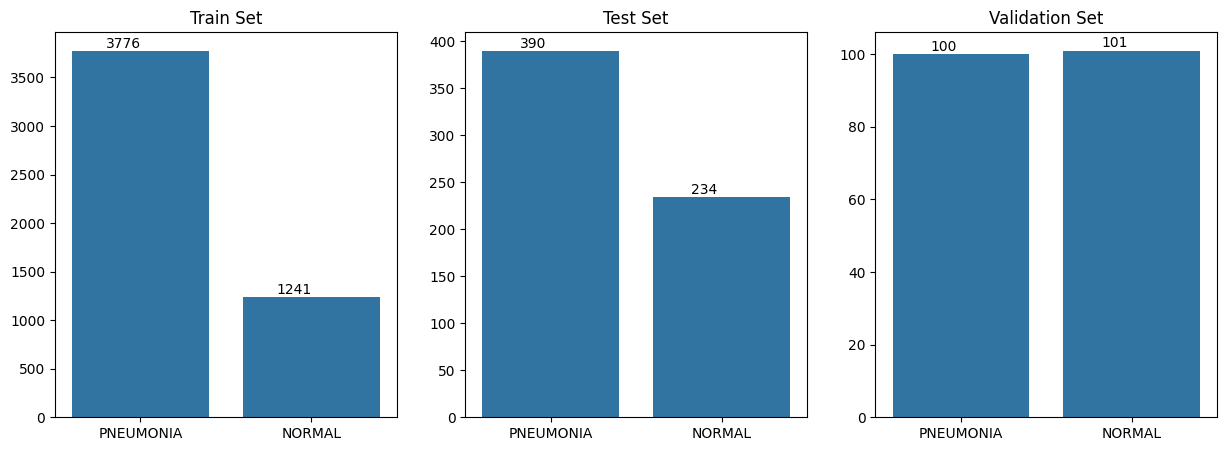

In [2]:

train_dir = "chest_xray/chest_xray/train"
test_dir = "chest_xray/chest_xray/test"
val_dir = "chest_xray_chest_xray/val"

# Function to get the count of samples in each class
def get_class_counts(directory):
    pneumonia_path = os.path.join(directory, 'PNEUMONIA')
    normal_path = os.path.join(directory, 'NORMAL')
    num_pneumonia = len(os.listdir(pneumonia_path))
    num_normal = len(os.listdir(normal_path))
    return int(num_pneumonia), int(num_normal)

# Get counts for each set
train_counts = get_class_counts(train_dir)
test_counts = get_class_counts(test_dir)
val_counts = get_class_counts(val_dir)

print("Training Data Size:",train_counts[0]+train_counts[1])
print("Testing Data Size:",test_counts[0]+test_counts[1])
print("Validation Data Size:",val_counts[0]+val_counts[1])

# Plotting
labels = ['PNEUMONIA', 'NORMAL',]
sets = ['Train', 'Test', 'Validation']
counts = [train_counts, test_counts, val_counts]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (set_name, count) in enumerate(zip(sets, counts)):
    barplot = sns.barplot(x=labels, y=list(count), ax=axes[i])  # Convert count to a list
    axes[i].set_title(f'{set_name} Set')

    for bar, count_value in zip(barplot.patches, count):
        barplot.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1,
                     f'{count_value}', ha='center', va='bottom', color='black', fontsize=10)

plt.show()



# X-ray Image Visualization


The provided Python code visually explores chest X-ray images from the pneumonia detection dataset. Two sets of visualizations are presented: the first set showcases X-rays labeled as "PNEUMONIA," while the second set features X-rays labeled as "NORMAL." Each set displays four sample images, providing an insight into the visual characteristics of the two classes.

The last segment of the code displays a single sample image from the "NORMAL" class, along with its dimensions. The accompanying color bar represents the intensity values of the image, where darker shades correspond to lower values and lighter shades to higher values. This image visualization aids in understanding the raw data and serves as an essential step in the exploratory data analysis of the chest X-ray dataset for pneumonia detection.

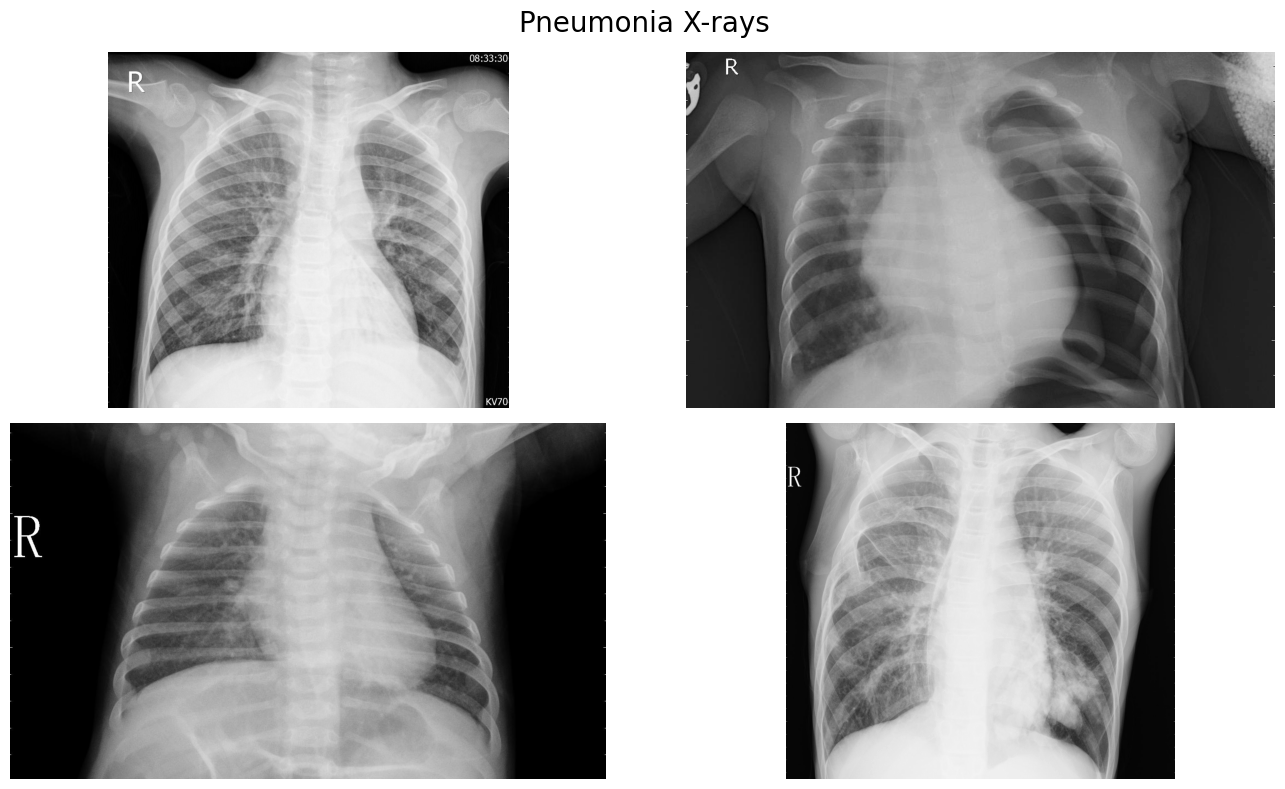

In [6]:
pneumonia = os.listdir(train_dir+"/PNEUMONIA")
pneumonia_dir = train_dir+"/PNEUMONIA"

plt.figure(figsize=(15, 8))
plt.suptitle('Pneumonia X-rays', size=20)

for i in range(4):
    plt.subplot(2, 2, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

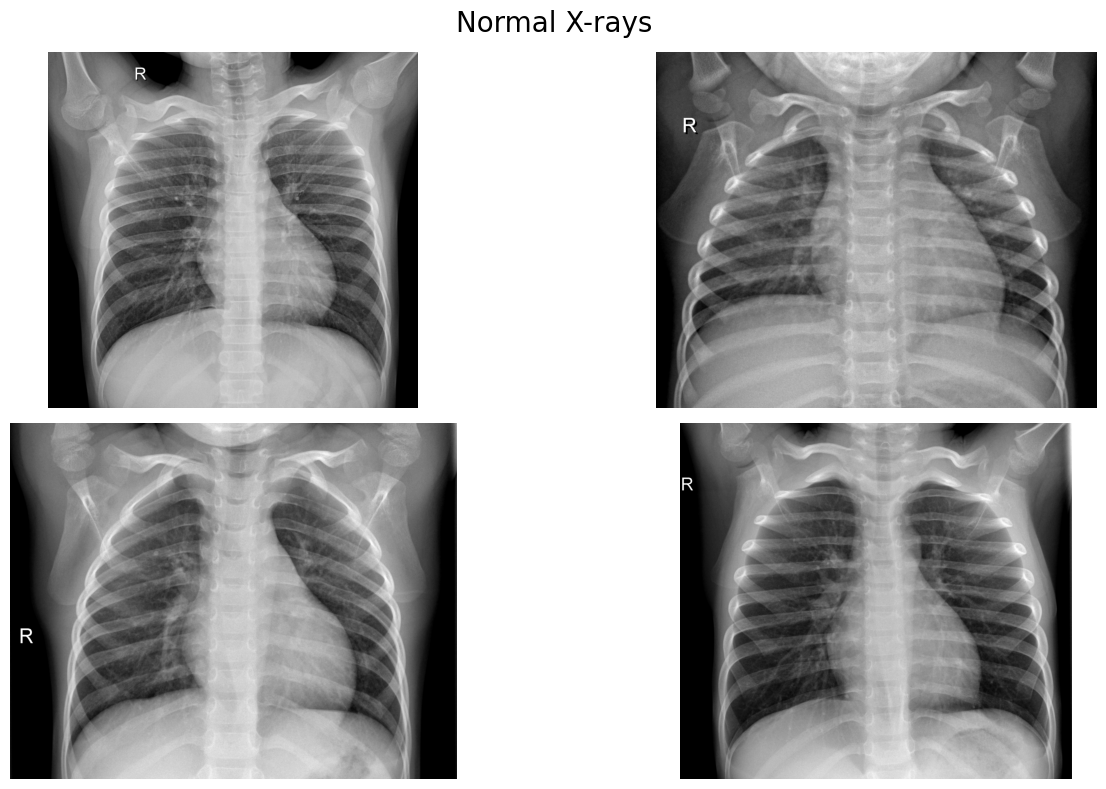

In [7]:
normal = os.listdir(train_dir+"/NORMAL")
normal_dir = train_dir+"/NORMAL"

plt.figure(figsize=(15, 8))
plt.suptitle('Normal X-rays', size=20)

for i in range(4):
    plt.subplot(2, 2, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

Image Dimension: (2476, 2572)


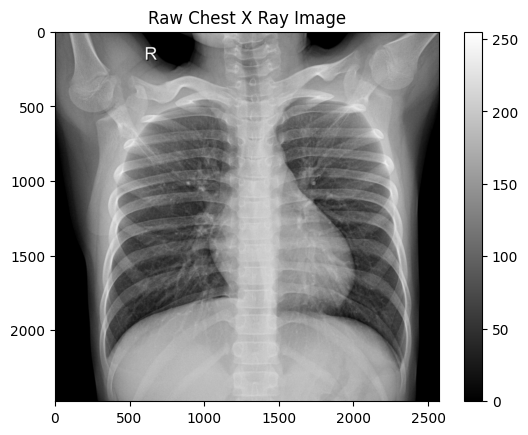

In [8]:
normal_img = os.listdir(train_dir+"/NORMAL")[0]
normal_dir = train_dir+"/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))

print("Image Dimension:" ,sample_img.shape)
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
plt.show()


# Analysis

In chest X-rays of individuals without pneumonia, a notable concentration of pixels around zero intensity suggests the absence of cloudy areas. This characteristic is indicative of clear lung fields typically observed in healthy individuals.

Conversely, in chest X-rays of individuals with pneumonia, there is an observable increase in the density of higher intensity pixels. This phenomenon often corresponds to the presence of whitish or cloudy areas in the X-ray images, which are commonly associated with lung inflammation or infection, characteristic of pneumonia.

# Data Preprocessing for Baseline models

The provided Python function, load_Data, performs data preprocessing for baseline models in the context of pneumonia detection using chest X-ray images. 

The function takes a directory path as input and loads image data from two categories: "NORMAL" and "PNEUMONIA." For each category, it reads images, resizes them to a standard size (100x100 pixels with three color channels), flattens the images, and normalizes the pixel values to the range [0, 1]. The flattened and normalized image data is then appended to the input array (X_arr), while the corresponding labels (0 for "NORMAL" and 1 for "PNEUMONIA") are appended to the output array (Y_arr).

Overall, this data preprocessing step prepares the image data for baseline models by standardizing the size and format, making it suitable for subsequent machine learning tasks.

In [17]:
def load_Data(dir):
    Categories=['NORMAL','PNEUMONIA']
    X_arr=[]#input array
    Y_arr=[] #output array
    for i in Categories:
        dem=0
        print(f'loading... category : {i}')
        path=os.path.join(dir,i)
        for img in os.listdir(path):
            if os.path.join(path,img).endswith(".DS_Store"):
                continue    
            img_array=imread(os.path.join(path,img))
            img_resized=resize(img_array,(100,100,3))
            X_arr.append(img_resized.flatten()/255)
            Y_arr.append(Categories.index(i))
            if dem==1341:break 
            else :dem+=1
        print(f'loaded category:{i} successfully')
    print("Completed!")
    return X_arr,Y_arr

In [18]:
X_train,y_train=load_Data(train_dir)

loading... category : NORMAL
loaded category:NORMAL successfully
loading... category : PNEUMONIA
loaded category:PNEUMONIA successfully
Completed!


In [13]:
X_test,y_test=load_Data(test_dir)

loading... category : NORMAL
loaded category:NORMAL successfully
loading... category : PNEUMONIA
loaded category:PNEUMONIA successfully
Completed!


# Model Performance Evaluators

The provided functions are used to evaluate the performance of a machine learning model for our pneumonia detection task. These evaluation metrics are essential for assessing the accuracy, precision, recall, and the Receiver Operating Characteristic (ROC) curve of the model.

**Functions:**

calculate_accuracy: This function calculates and returns the training and testing accuracy of the model.

generate_classification_report: It generates a detailed classification report including precision, recall, and F1-score for each class.

plot_confusion_matrix: The function plots a heatmap of the confusion matrix, providing insights into the model's performance in terms of true positive, true negative, false positive, and false negative predictions.

plot_roc_auc_curve: This function plots the Receiver Operating Characteristic (ROC) curve and calculates the Area Under the Curve (AUC) score, which is crucial for binary classification models.

**Significance:**

These evaluation tools aid in understanding the strengths and weaknesses of the machine learning model. The accuracy metrics and visualizations, such as the confusion matrix and ROC curve, offer comprehensive insights into how well the model is performing, helping in making informed decisions about potential improvements or adjustments in the model architecture or hyperparameters.

In [475]:
def calculate_accuracy(clf,X_test, y_test):
    y_test_pred = clf.predict(X_test)
    
    # accuracy calculation
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    return test_accuracy

def generate_classification_report(clf, X_test, y_test):
    # Generate classification report as a string
    report_str = classification_report(y_test, clf.predict(X_test), output_dict=True)
    
    # Convert the classification report string to a DataFrame
    report_df = pd.DataFrame(report_str).transpose()
    
    return report_df

def plot_confusion_matrix(clf, X_test, y_test):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(clf, X_test, y_test):
    # Calculate probabilities for the positive class
    y_probs = clf.predict_proba(X_test)[:, 1]
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)
    # Plot ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


# First Baseline Model - Logistic Regression 

Logistic Regression is employed as the initial baseline model in the pneumonia detection project. This classic machine learning algorithm is chosen for its simplicity and effectiveness in binary classification tasks which makes it an ideal as a starting point for understanding the inherent complexities of the dataset. It serves as a benchmark against more complex and advanced machine learning and deep learning models in the subsequent stages of the project.

**Implementation:**

The code snippet utilizes the LogisticRegression class from scikit-learn, with the 'liblinear' solver and regularization parameter C set to 1. The model is trained on the preprocessed dataset (X_train and y_train). The choice of logistic regression for this baseline model enables quick model training and inference.


In [26]:
LGR = LogisticRegression(solver='liblinear',C=1)
LGR.fit(X_train,y_train)


LogisticRegression(C=1, solver='liblinear')

# Model Performance Evaluation

In [32]:
# Calculate accuracy
accuracy = calculate_accuracy(LGR,X_test, y_test)
print("Logistic Regression Accuracy:", accuracy)

Logistic Regression Accuracy: 0.8125


In [33]:
# Generate classification report
report = generate_classification_report(LGR,X_test,y_test)

print("Classification Report:")
print (report)



Classification Report:
              precision    recall  f1-score   support
0              0.800000  0.666667  0.727273  234.0000
1              0.818182  0.900000  0.857143  390.0000
accuracy       0.812500  0.812500  0.812500    0.8125
macro avg      0.809091  0.783333  0.792208  624.0000
weighted avg   0.811364  0.812500  0.808442  624.0000


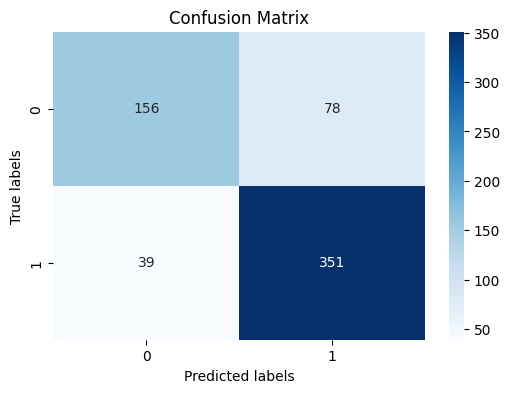

In [34]:
# Calculate confusion matrix
conf_matrix = plot_confusion_matrix(LGR, X_test, y_test)


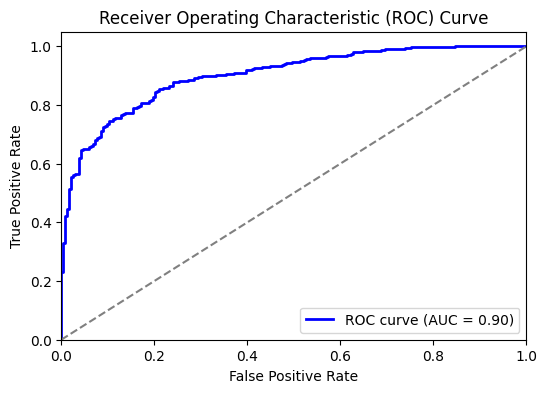

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
roc_curve = plot_roc_curve(LGR, X_test, y_test)

# Decision Tree Classifier

In this segment, a Decision Tree Classifier is employed as a follow-up to Logistic Regression for pneumonia detection. Decision trees utilizes a tree-like structure of decisions based on input features to classify instances.

**Implementation:**

The Decision Tree Classifier is instantiated and fitted to the training data (X_train and y_train) with the random_state set to 42 for reproducibility. This model is particularly adept at handling non-linear relationships and can uncover complex decision boundaries, potentially enhancing the model's ability to discern subtle patterns in the dataset.


In [36]:
# Decision Tree Classifier
DT = DecisionTreeClassifier(random_state=42)
DT.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [37]:
# Calculate accuracy
accuracy = calculate_accuracy(DT,X_test, y_test)
print("Decision Tree Accuracy:", accuracy)

Decision Tree Accuracy: 0.7724358974358975


In [38]:
# Generate classification report
report = generate_classification_report(DT,X_test,y_test)

print("Classification Report:")
print (report)

Classification Report:
              precision    recall  f1-score     support
0              0.752747  0.585470  0.658654  234.000000
1              0.780543  0.884615  0.829327  390.000000
accuracy       0.772436  0.772436  0.772436    0.772436
macro avg      0.766645  0.735043  0.743990  624.000000
weighted avg   0.770120  0.772436  0.765325  624.000000


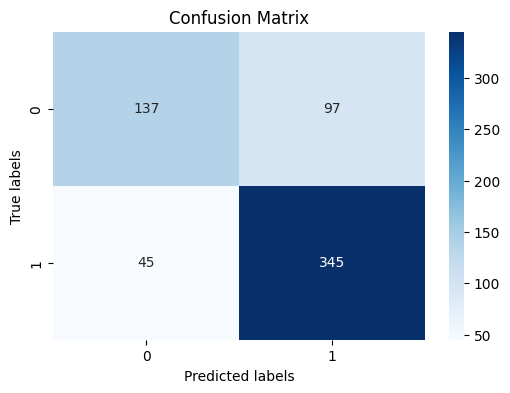

In [39]:
# Calculate confusion matrix
conf_matrix = plot_confusion_matrix(DT, X_test, y_test)

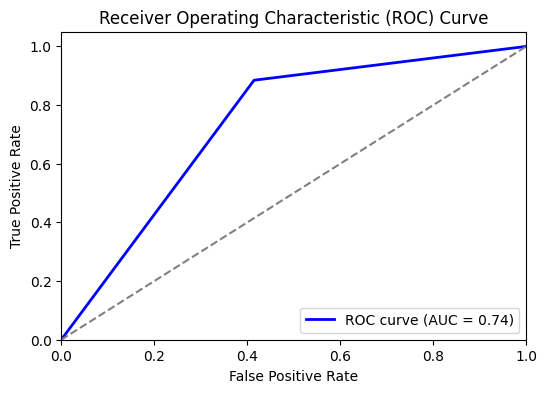

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
roc_curve = plot_roc_curve(DT, X_test, y_test)

# Random Forest Classifier

In the process of refining predictive accuracy, the Random Forest algorithm is employed. Random Forest is an ensemble learning method that combines the outputs of multiple decision trees, reducing the risk of overfitting and improving the model's robustness.

**Implementation:** 

The Random Forest is configured with 5 decision trees (n_estimators=5) to constitute a robust ensemble. The random_state parameter ensures reproducibility, enabling consistent results for subsequent runs.



In [444]:
# Random Forest Classifier
RF = RandomForestClassifier(n_estimators=5, random_state=42) 
RF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=42)

In [445]:
# Calculate accuracy
accuracy = calculate_accuracy(RF,X_test, y_test)
print("Random Forest Accuracy:", accuracy)

Random Forest Accuracy: 0.8173076923076923


# Grid Search for Hyperparameter Tuning

In [450]:
# Random Forest Classifier
param_grid = {
    'n_estimators': [10,15,20,25,30,50,100,200,300,500]
}
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....................................n_estimators=10; total time=   2.0s
[CV] END ....................................n_estimators=10; total time=   1.9s
[CV] END ....................................n_estimators=10; total time=   2.2s
[CV] END ....................................n_estimators=15; total time=   3.9s
[CV] END ....................................n_estimators=15; total time=   4.1s
[CV] END ....................................n_estimators=15; total time=   4.4s
[CV] END ....................................n_estimators=20; total time=   5.0s
[CV] END ....................................n_estimators=20; total time=   4.4s
[CV] END ....................................n_estimators=20; total time=   4.9s
[CV] END ....................................n_estimators=25; total time=   7.6s
[CV] END ....................................n_estimators=25; total time=   6.7s
[CV] END ....................................n_e

{'n_estimators': 500}

In [455]:
# Calculate accuracy
accuracy = calculate_accuracy(grid_search,X_test, y_test)
print("Random Forest Accuracy:", accuracy)

Random Forest Accuracy: 0.8573717948717948


In [456]:
# Generate classification report
report = generate_classification_report(grid_search,X_test,y_test)

print("Classification Report:")
print (report)

Classification Report:
              precision    recall  f1-score     support
0              0.923977  0.675214  0.780247  234.000000
1              0.832230  0.966667  0.894425  390.000000
accuracy       0.857372  0.857372  0.857372    0.857372
macro avg      0.878103  0.820940  0.837336  624.000000
weighted avg   0.866635  0.857372  0.851608  624.000000


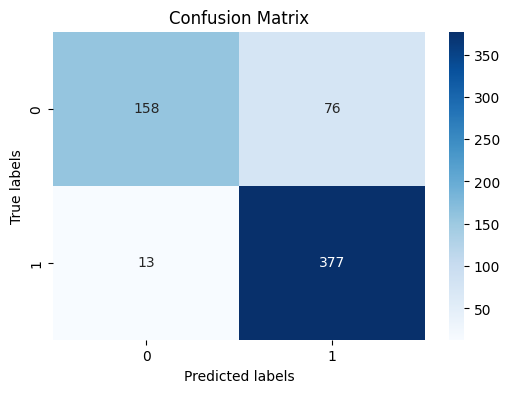

In [476]:
# Calculate confusion matrix
conf_matrix = plot_confusion_matrix(grid_search, X_test, y_test)

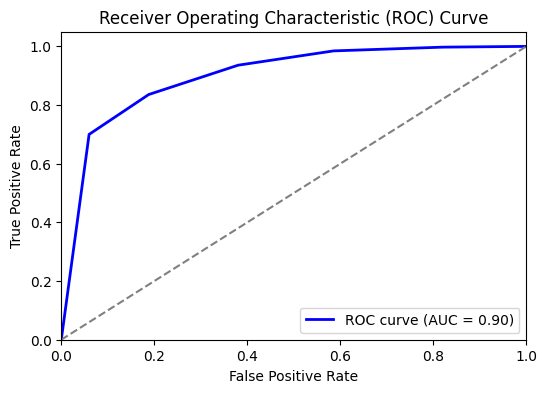

In [477]:
from sklearn.metrics import roc_curve, roc_auc_score
roc_curve = plot_roc_curve(grid_search,X_test, y_test)

# Transitioning to Deep Learning: Unlocking Potential Beyond Traditional Models

Having explored traditional models like Logistic Regression, Decision Trees, and Random Forests for our task, the journey now unfolds into the realm of Deep Learning, specifically Neural Networks. Deep Learning introduces architectures that can learn more complex patterns and relationships within complex datasets.

Now, as we switch from regular models to Deep Learning, it's like moving from traditional tools to a supercharged detective for our job of telling if someone has pneumonia from their X-ray. Think of it as upgrading from a magnifying glass to a powerful detective gadget!

**Why Deep Learning?**

Because this new detective, inspired by how our brain works, is super good at spotting tricky details in X-ray pictures. It's like having a detective that can see and understand things that regular tools might miss.

**Why Pixels Matter:** 

In our journey, we want not just to be right but to really understand the details in those pixelated X-ray pictures. Deep Learning helps us look at each tiny square (pixel) to figure out the story it's telling us about pneumonia.





# Data Preprocessing


Before training our neural networks, we'll first modify our images to be better suited for training a neural network. For this task we'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation..

**Data Augmentation:**

The ImageDataGenerator class supports various augmentation techniques, such as random horizontal flipping, rotation, width shift, shear, and zoom. These techniques introduce diversity into our dataset, helping the model become robust to different angles and positions.

**Normalization:**

To facilitate model training, the generator transforms batch values, ensuring their mean is 0 and standard deviation is 1. This normalization enhances the efficiency of the learning process.

**Handling Single-Channel Images:**

Since our X-ray images are grayscale (single-channel), the generator automatically converts them to a three-channel format by replicating the grayscale values across all channels. This adjustment is crucial because the pre-trained model we'll use expects three-channel inputs.

In [3]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Building Data Generator

Now we will build a data generator for training , testing and validation data.

Our Validation and Testing data generator will be different from that of Training.

**Why can't use the same generator as for the training data?**

Look back at the generator we wrote for the training data.

It normalizes each image per batch it means it uses batch statistics. We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time because we will process one image at a time. Also it will make sure that the model should not have any information about the test data for effective model testing. 

What we need to do is to normalize incoming test data using the statistics computed from the training set.

In [4]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=16, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180,180),
                                           classes=['NORMAL', 'PNEUMONIA'])

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180),
                                                classes=['NORMAL', 'PNEUMONIA'])

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle= False, 
                                            class_mode='binary',
                                            target_size=(180, 180),
                                            classes=['NORMAL', 'PNEUMONIA'])




Found 5015 images belonging to 2 classes.
Found 201 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Handling Imbalance Dataset Issue

When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

In [286]:
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}



print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.75
Weight for class 1: 0.25


# Neural Network Optimization using Early Stopping Callback: 

The early stopping callback is a technique used during neural network training to monitor the validation loss. If there is no improvement in validation loss for a specified number of epochs (patience), the training is stopped to prevent overfitting. This callback helps in avoiding unnecessary computation and ensures that the model retains the best weights observed during training, promoting efficiency and preventing overfitting.

In [75]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=3,           
    restore_best_weights=True  
)

# Deep Learning Model Performance Evaluators

**Why These evaluators are so important?**, 

It is really necessary to know that false negatives are more ‘costly’ than false positives in models predicting results on medical datasets like in our case.

In [6]:
def evaluate_model(model, test_generator):
    test_loss, test_accuracy = model.evaluate(test_generator)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)

def plot_training_history(history):
    plt.figure(figsize=(12, 8))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val_Loss')
    plt.legend()
    plt.title('Loss Evolution')

    # Plot accuracy
    if 'accuracy' in history.history:
        acc_key = 'accuracy'
        val_acc_key = 'val_accuracy'
    else:
        acc_key = 'binary_accuracy'
        val_acc_key = 'val_binary_accuracy'
  

    plt.subplot(2, 2, 2)
    plt.plot(history.history[acc_key], label='Accuracy')
    plt.plot(history.history[val_acc_key], label='Val_Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

def generate_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return pd.DataFrame(report).transpose()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


# First Baseline Simple Neural Network Architecture

We've embarked on constructing a straightforward neural network architecture using the Keras library. The model begins with a Flatten layer, transforming our 180x180x3 input images into a flat vector. Following this, we introduce two dense (fully connected) layers, each with rectified linear unit (ReLU) activation functions, promoting non-linearity in the model.

The final layer, a Dense layer with a single neuron and a **sigmoid activation function**, serves as the output layer. The sigmoid function is apt for **binary classification** tasks, making our neural network well-suited for distinguishing between normal and pneumonia X-ray images.

In [78]:
# Initialize the model
model = Sequential()

# Flatten the input image
model.add(Flatten(input_shape=(180, 180, 3)))

# Add dense layers with dropout for regularization
model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))



In [79]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 97200)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               24883456  
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24916481 (95.05 MB)
Trainable params: 24916481 (95.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
history = model.fit(train,class_weight = class_weight, epochs=10, batch_size=32, validation_data=validation, callbacks=[early_stopping_callback])

Epoch 1/10
627/627 [==============================] - 53s 84ms/step - loss: 1.1744 - accuracy: 0.7587 - val_loss: 1.0926 - val_accuracy: 0.8209
Epoch 2/10
627/627 [==============================] - 53s 84ms/step - loss: 0.2891 - accuracy: 0.7948 - val_loss: 1.5477 - val_accuracy: 0.7164
Epoch 3/10
627/627 [==============================] - 53s 84ms/step - loss: 0.1863 - accuracy: 0.8177 - val_loss: 0.4963 - val_accuracy: 0.8706
Epoch 4/10
627/627 [==============================] - 53s 85ms/step - loss: 0.2093 - accuracy: 0.8233 - val_loss: 0.9078 - val_accuracy: 0.8358
Epoch 5/10
627/627 [==============================] - 54s 87ms/step - loss: 0.1644 - accuracy: 0.8582 - val_loss: 0.4177 - val_accuracy: 0.8458
Epoch 6/10
627/627 [==============================] - 52s 84ms/step - loss: 0.1679 - accuracy: 0.8522 - val_loss: 0.4284 - val_accuracy: 0.8657
Epoch 7/10
627/627 [==============================] - 54s 85ms/step - loss: 0.1492 - accuracy: 0.8562 - val_loss: 0.3821 - val_accuracy:

# Model Performance Evaluation

In [82]:
evaluation= evaluate_model(model,test)

624/624 [==============================] - 6s 9ms/step - loss: 0.4810 - accuracy: 0.8045
Test Loss: 0.48098570108413696
Test Accuracy: 0.8044871687889099


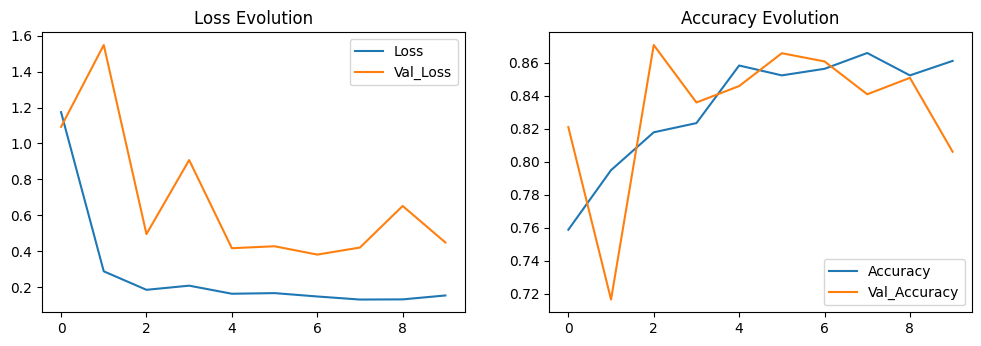

In [83]:
plot_training_history(history)

In [84]:
pred = model.predict(test)
classification_report = generate_classification_report(test.classes, pred > 0.5)
print(classification_report)

624/624 [==============================] - 6s 9ms/step
              precision    recall  f1-score    support
0              0.792271  0.700855  0.743764  234.00000
1              0.832134  0.889744  0.859975  390.00000
accuracy       0.818910  0.818910  0.818910    0.81891
macro avg      0.812202  0.795299  0.801870  624.00000
weighted avg   0.817185  0.818910  0.816396  624.00000


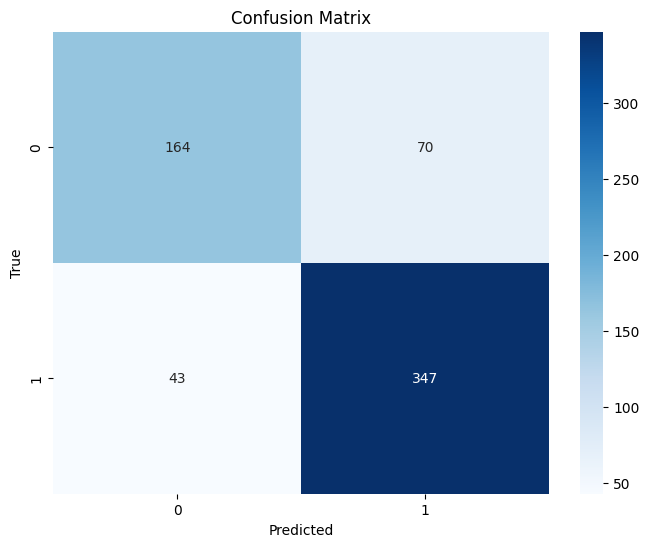

In [85]:
pred_classes = (pred > 0.5).astype(int)
plot_confusion_matrix(test.classes, pred_classes)

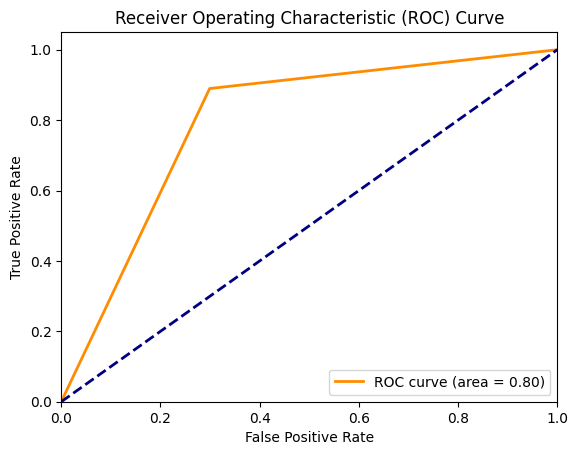

In [86]:
plot_roc_curve(test.classes, pred > 0.5)

# Pneumonia Detection with Convolutional Neural Networks
Computer Vision can be realized using Convolutional neural networks (CNN) They are neural networks making features extraction over an image before classifying it. The feature extraction performed consists of three basic operations:

Filter an image for a particular feature (convolution)
Detect that feature within the filtered image (using the ReLU activation)
Condense the image to enhance the features (maximum pooling)
The convolution process is illustrated below

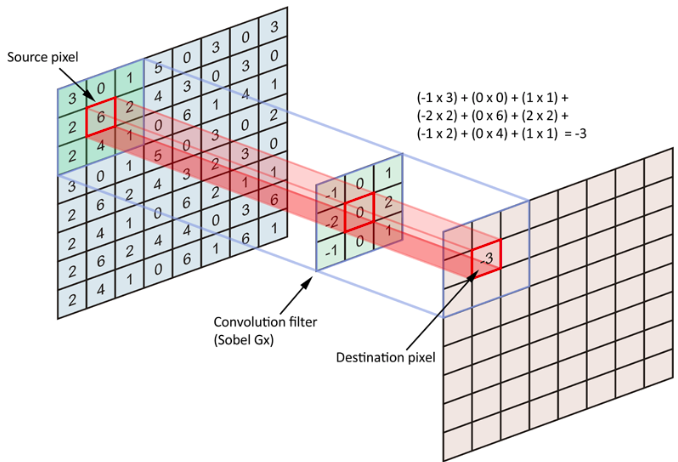

Using convolution filters with different dimensions or values results in differents features extracted

Features are then detected using the reLu activation on each destination pixel

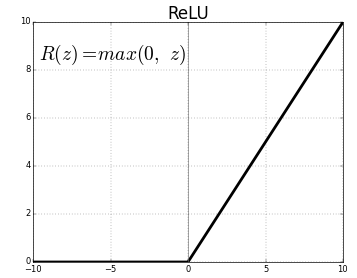

Features are the enhanced with MaxPool layers

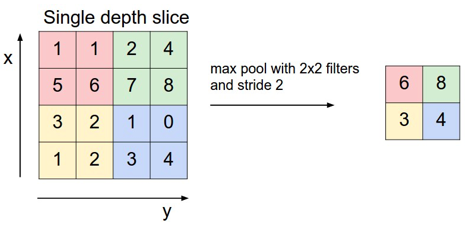

The stride parameters determines the distance between each filters. The padding one determines if we ignore the borderline pixels or not (adding zeros helps the neural network to get information on the border)

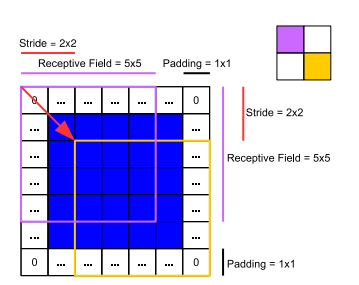

The outputs are then concatened in Dense layers

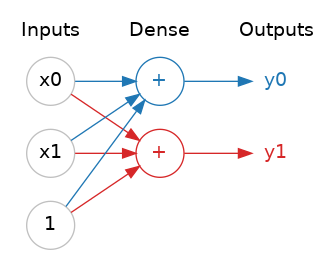

By using a sigmoid activation, the neural network determines which class the image belongs to

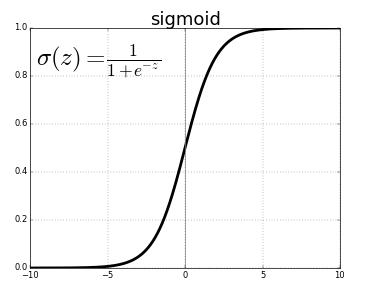

In [117]:
inputs = layers.Input(shape=(180, 180, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(units=1, activation="sigmoid")(x)

model_c = models.Model(inputs=inputs, outputs=outputs)

In [118]:
model_c.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [119]:
history = model_c.fit(train,class_weight = class_weight ,epochs=10, batch_size=32, validation_data=validation, verbose=1, callbacks=[early_stopping_callback])

Epoch 1/10
627/627 [==============================] - 82s 130ms/step - loss: 0.1359 - accuracy: 0.8588 - val_loss: 0.1749 - val_accuracy: 0.9254
Epoch 2/10
627/627 [==============================] - 89s 142ms/step - loss: 0.0917 - accuracy: 0.9184 - val_loss: 0.1281 - val_accuracy: 0.9453
Epoch 3/10
627/627 [==============================] - 92s 147ms/step - loss: 0.0898 - accuracy: 0.9296 - val_loss: 0.1323 - val_accuracy: 0.9502
Epoch 4/10
627/627 [==============================] - 98s 156ms/step - loss: 0.0830 - accuracy: 0.9298 - val_loss: 0.1501 - val_accuracy: 0.9403
Epoch 5/10
627/627 [==============================] - 100s 160ms/step - loss: 0.0875 - accuracy: 0.9324 - val_loss: 0.1260 - val_accuracy: 0.9602
Epoch 6/10
627/627 [==============================] - 94s 149ms/step - loss: 0.0805 - accuracy: 0.9368 - val_loss: 0.2119 - val_accuracy: 0.9303
Epoch 7/10
627/627 [==============================] - 92s 147ms/step - loss: 0.0995 - accuracy: 0.9370 - val_loss: 0.1635 - val_a

In [213]:
evaluation= evaluate_model(model_c,test)

624/624 [==============================] - 5s 8ms/step - loss: 0.3441 - accuracy: 0.8686
Test Loss: 0.34409424662590027
Test Accuracy: 0.8685897588729858


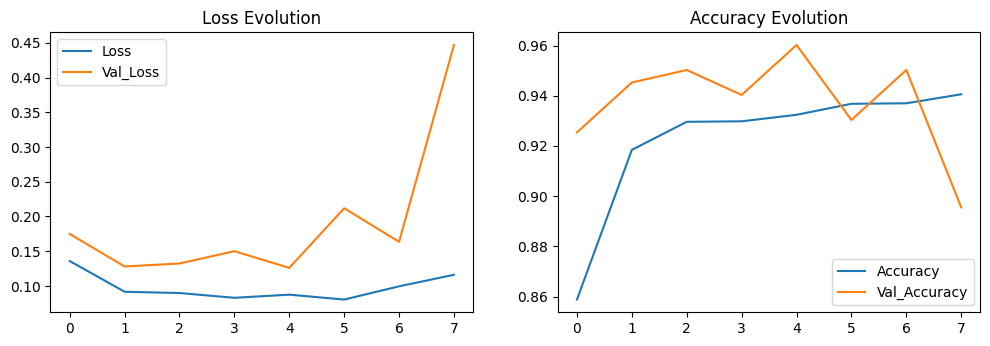

In [121]:
plot_training_history(history)

In [217]:
pred = model_c.predict(test)
classification_report_df = generate_classification_report(test.classes, pred > 0.5)
print(classification_report_df)


624/624 [==============================] - 5s 8ms/step
              precision    recall  f1-score     support
0              0.872038  0.786325  0.826966  234.000000
1              0.878935  0.930769  0.904110  390.000000
accuracy       0.876603  0.876603  0.876603    0.876603
macro avg      0.875486  0.858547  0.865538  624.000000
weighted avg   0.876348  0.876603  0.875181  624.000000


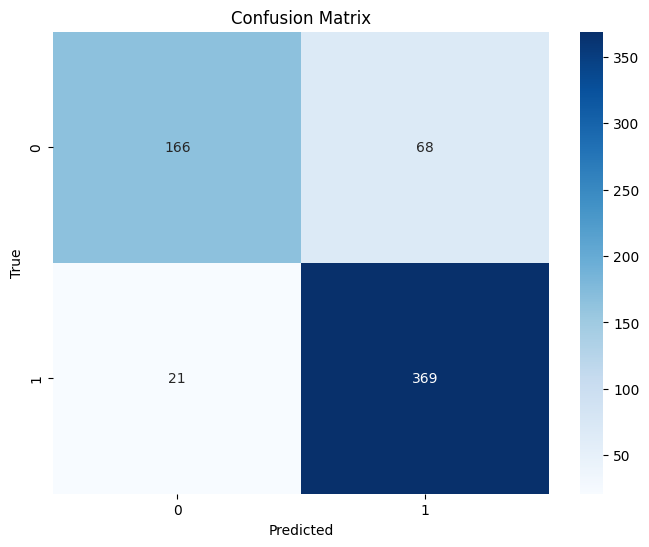

In [216]:
pred_classes = (pred > 0.5).astype(int)
plot_confusion_matrix(test.classes, pred_classes)

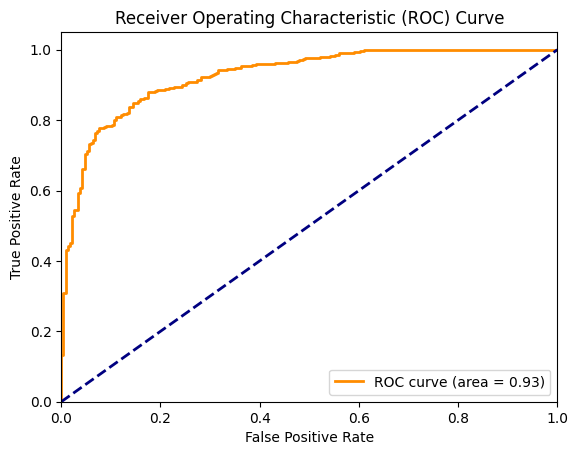

In [12]:
plot_roc_curve(test.classes, pred)

# Transfer Learning

The second approach, called transfer learning, consists of using a pretrained model as a feature extractor. In this notebook, the selected model was the **InceptionV3** available on the Keras Package.

This model was already trained in ImageNet. What we do here is to set include_top to false, removing the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers as freezed. Then, we include our last few layers, including the one responsible for generating the output that is our classifier.

In [325]:
base_model = inception_v3.InceptionV3(include_top= False, weights= "imagenet", input_shape=(180,180, 3), pooling= 'max')
callback_lr = ReduceLROnPlateau(monitor='val_loss', patience = 3, cooldown=0, verbose=1, factor=0.6, min_lr=0.000001)


base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(180,180, 3))
    
    x = base_model(inputs)

    # Head
    #reshape the output of the base model to ndim =4
    x = layers.Reshape((1, 1, 2048))(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model


In [326]:
from keras import layers

keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = 'adam', metrics=['accuracy'])

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 reshape (Reshape)           (None, 1, 1, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

In [327]:
#save best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_pretrained.fit(train,
                                batch_size=16,
                                epochs=20,
                                validation_data=validation,
                                class_weight={0:12, 1:0.5},
                                callbacks=[callback_lr, model_checkpoint_callback, early_stopping_callback])

Epoch 1/20
314/314 [==============================] - 80s 236ms/step - loss: 1.8024 - accuracy: 0.6189 - val_loss: 0.4280 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 2/20
314/314 [==============================] - 82s 261ms/step - loss: 0.5253 - accuracy: 0.7513 - val_loss: 0.2356 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 3/20
314/314 [==============================] - 86s 274ms/step - loss: 0.4782 - accuracy: 0.7799 - val_loss: 0.2759 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 4/20
314/314 [==============================] - 88s 278ms/step - loss: 0.4352 - accuracy: 0.7874 - val_loss: 0.2675 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 5/20
314/314 [==============================] - 89s 283ms/step - loss: 0.4667 - accuracy: 0.7852 - val_loss: 0.2326 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 6/20
314/314 [==============================] - 90s 288ms/step - loss: 0.3922 - accuracy: 0.8066 - val_loss: 0.2157 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 7/20
314/314 [==============================] 

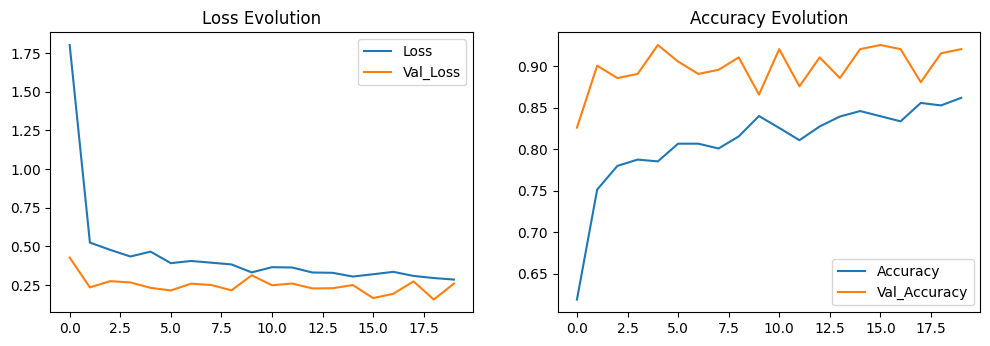

In [344]:
plot_training_history(history)

624/624 [==============================] - 17s 26ms/step


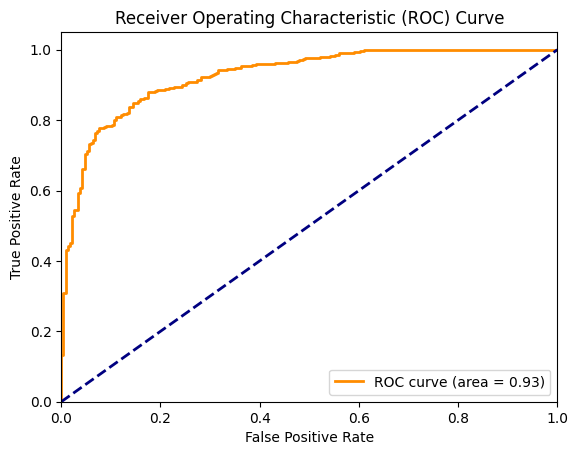

In [9]:
plot_roc_curve(test.classes,pred)

In [341]:
evaluation= evaluate_model(model_pretrained,test)
model_pretrained.save('model_pretrained_final.h5')

624/624 [==============================] - 16s 25ms/step - loss: 0.3497 - accuracy: 0.8750
Test Loss: 0.34968653321266174
Test Accuracy: 0.875


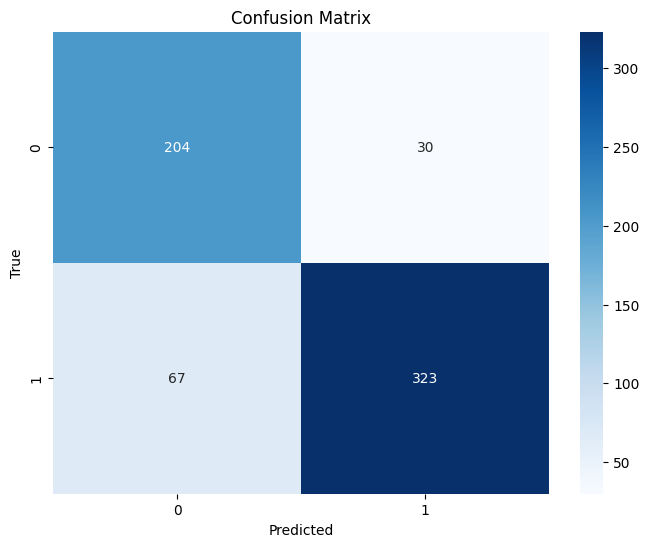

In [342]:
# pred = model_pretrained.predict(test)
pred_classes = (pred > 0.5).astype(int)
plot_confusion_matrix(test.classes, pred_classes)

In [348]:
classification_report_df = generate_classification_report(test.classes, pred > 0.5)
print(classification_report_df)

              precision    recall  f1-score     support
0              0.748175  0.876068  0.807087  234.000000
1              0.917143  0.823077  0.867568  390.000000
accuracy       0.842949  0.842949  0.842949    0.842949
macro avg      0.832659  0.849573  0.837327  624.000000
weighted avg   0.853780  0.842949  0.844887  624.000000


# Fine Tuning

Our last approach is called Fine Tuning. In the last section, all the layers from the pretrained model were ‘frozen’, preserving the weights calculated during its training on the ImageNet dataset. Now, we are going to unfreeze a few of its last layers and continue the training, tuning the weights from these layers according to our dataset.

In [400]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [352]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [401]:
keras.backend.clear_session()
model_pretrained = keras.models.load_model('model_pretrained_final.h5')
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = 'adam', metrics=['accuracy'])

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 reshape (Reshape)           (None, 1, 1, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

In [402]:
#save best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model_pretrained.fit(train,
                                batch_size=16,
                                epochs=25,
                                validation_data=validation,
                                class_weight={0:12, 1:0.5},
                                callbacks=[callback_lr, model_checkpoint_callback])

Epoch 1/25
314/314 [==============================] - 82s 253ms/step - loss: 0.4188 - accuracy: 0.8098 - val_loss: 0.3043 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 2/25
314/314 [==============================] - 92s 294ms/step - loss: 0.3676 - accuracy: 0.8116 - val_loss: 0.2876 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 3/25
314/314 [==============================] - 93s 295ms/step - loss: 0.3601 - accuracy: 0.8191 - val_loss: 0.4489 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 4/25
314/314 [==============================] - 95s 303ms/step - loss: 0.3519 - accuracy: 0.8263 - val_loss: 0.1962 - val_accuracy: 0.9403 - lr: 0.0010
Epoch 5/25
314/314 [==============================] - 100s 318ms/step - loss: 0.3634 - accuracy: 0.8255 - val_loss: 0.2378 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 6/25
314/314 [==============================] - 110s 349ms/step - loss: 0.3509 - accuracy: 0.8209 - val_loss: 0.2766 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 7/25
314/314 [==============================

In [438]:
evaluation= evaluate_model(model_pretrained,test)


624/624 [==============================] - 16s 26ms/step - loss: 0.3323 - accuracy: 0.8830
Test Loss: 0.3323107063770294
Test Accuracy: 0.8830128312110901


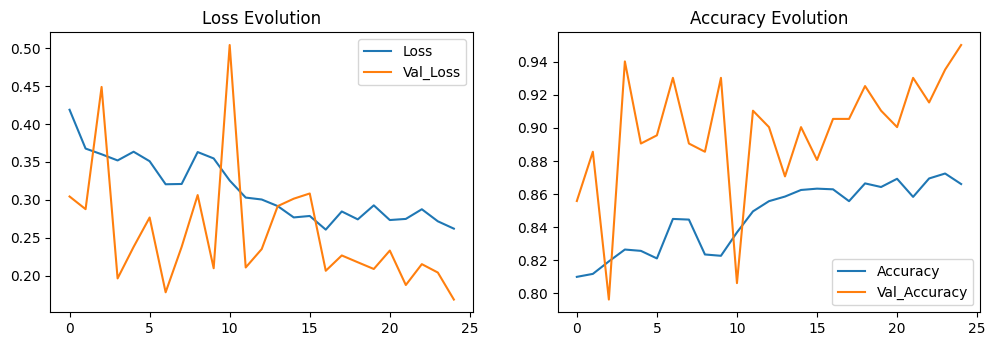

In [404]:
plot_training_history(history)

624/624 [==============================] - 16s 25ms/step


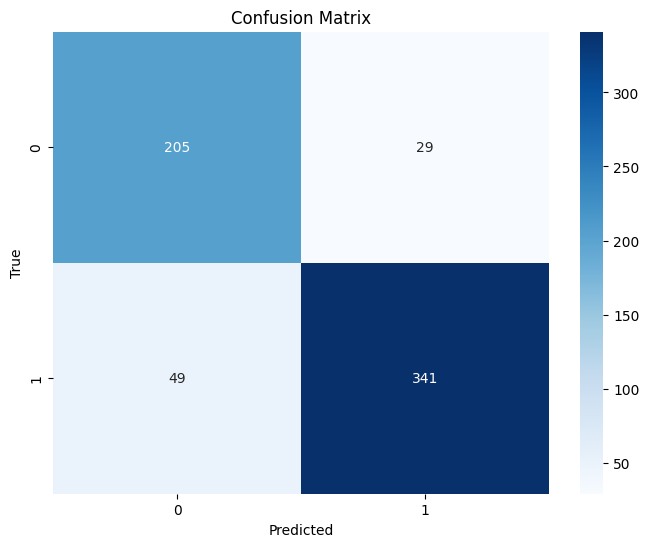

In [466]:
pred = model_pretrained.predict(test)
pred_classes = (pred > 0.5).astype(int)
plot_confusion_matrix(test.classes, pred_classes)

In [467]:
classification_report_df = generate_classification_report(test.classes, pred>0.5)
print(classification_report_df)

              precision    recall  f1-score  support
0              0.807087  0.876068  0.840164  234.000
1              0.921622  0.874359  0.897368  390.000
accuracy       0.875000  0.875000  0.875000    0.875
macro avg      0.864354  0.875214  0.868766  624.000
weighted avg   0.878671  0.875000  0.875917  624.000


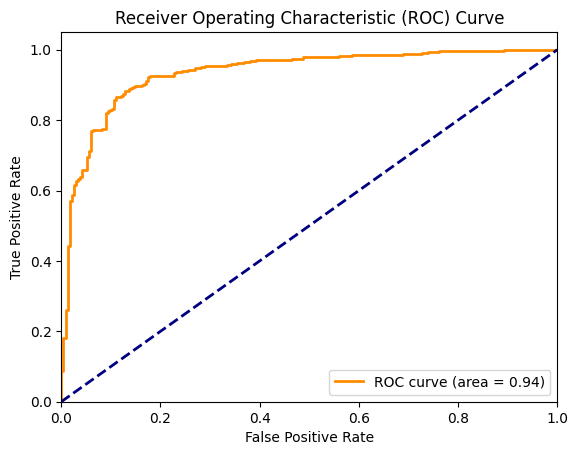

In [468]:
pred = model_pretrained.predict(test)
plot_roc_curve(test.classes, pred)